In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [64]:
import pandas as pd
from utils import one_hot_to_index, filter_data_for_X, filter_others_data_for_X
from utils import transform_labels_model
from utils import to_one_hot
from utils import save_filtered_data

# Load the data from L1_8000rpm_data/ folder
X_train = pd.read_csv('8000rpm_data_z-score/train_sample_fft_scaled.csv')
X_test = pd.read_csv('8000rpm_data_z-score/test_sample_fft_scaled.csv')
y_train = pd.read_csv('8000rpm_data_z-score/train_label.csv')
y_test = pd.read_csv('8000rpm_data_z-score/test_label.csv')

# Apply the one-hot to index conversion
y_train = one_hot_to_index(y_train)
y_test = one_hot_to_index(y_test)

# Apply the filter to the train and test sets
X_train_model2, y_train_model2 = filter_others_data_for_X(y_train, X_train, [4, 5])
X_test_model2, y_test_model2 = filter_others_data_for_X(y_test, X_test, [4, 5])

# Apply the transformation to the labels
y_train_model2 = transform_labels_model(y_train_model2, [6,7,8,9], [4,5,6,7])
y_test_model2 = transform_labels_model(y_test_model2, [6,7,8,9], [4,5,6,7])
y_train_model1 = transform_labels_model(y_train, [1,2,3,4,5,6,7,8,9], [1,1,1,2,3,1,1,1,1])
y_test_model1 = transform_labels_model(y_test, [1,2,3,4,5,6,7,8,9], [1,1,1,2,3,1,1,1,1])

# Apply one-hot encoding to the labels for Model 2
y_train_model2_onehot = to_one_hot(y_train_model2)
y_test_model2_onehot = to_one_hot(y_test_model2)

y_train_model1_onehot = to_one_hot(y_train_model1)
y_test_model1_onehot = to_one_hot(y_test_model1)

# Save the filtered data for Model 2
save_filtered_data(
    X_train_model2, y_train_model2_onehot, 
    'data2/train_sample_model2.csv', 
    'data2/train_label_model2.csv')
save_filtered_data(
    X_test_model2, y_test_model2_onehot, 
    'data2/test_sample_model2.csv', 
    'data2/test_label_model2.csv')
save_filtered_data(
    X_train, y_train_model1_onehot, 
    'data2/train_sample_model1.csv', 
    'data2/train_label_model1.csv')
save_filtered_data(
    X_test, y_test_model1_onehot, 
    'data2/test_sample_model1.csv', 
    'data2/test_label_model1.csv')

print("Filtered data has been saved for Model 1 and 2.")

Filtered data has been saved for Model 1 and 2.


In [2]:
# Load the data from L1_8000rpm_data/ folder
X_train2 = pd.read_csv('data2/train_sample_model2.csv').values
X_test2 = pd.read_csv('data2/test_sample_model2.csv').values
y_train2 = pd.read_csv('data2/train_label_model2.csv').values
y_test2 = pd.read_csv('data2/test_label_model2.csv').values

# Convert data to PyTorch tensors
X_train2 = torch.tensor(X_train2, dtype=torch.float32).unsqueeze(1).to(device)
X_test2 = torch.tensor(X_test2, dtype=torch.float32).unsqueeze(1).to(device)
y_train2 = torch.tensor(y_train2, dtype=torch.long).to(device)
y_test2 = torch.tensor(y_test2, dtype=torch.long).to(device)

In [3]:
# Load the data from L1_8000rpm_data/ folder
X_train1 = pd.read_csv('data2/train_sample_model1.csv').values
X_test1 = pd.read_csv('data2/test_sample_model1.csv').values
y_train1 = pd.read_csv('data2/train_label_model1.csv').values
y_test1 = pd.read_csv('data2/test_label_model1.csv').values

# Convert data to PyTorch tensors
X_train1 = torch.tensor(X_train1, dtype=torch.float32).unsqueeze(1).to(device)
X_test1 = torch.tensor(X_test1, dtype=torch.float32).unsqueeze(1).to(device)
y_train1 = torch.tensor(y_train1, dtype=torch.long).to(device)
y_test1 = torch.tensor(y_test1, dtype=torch.long).to(device)

In [5]:
# Create DataLoader for batching
train_dataset1 = TensorDataset(X_train1, y_train1)
test_dataset1 = TensorDataset(X_test1, y_test1)
train_loader1 = DataLoader(train_dataset1, batch_size=32, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=32, shuffle=False)

In [6]:
# Create DataLoader for batching
train_dataset2 = TensorDataset(X_train2, y_train2)
test_dataset2 = TensorDataset(X_test2, y_test2)
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

In [ ]:
from model import CNN

model1 = CNN().to(device)
model2 = CNN(num_class=3).to(device)

In [9]:
# Ensure the models are in evaluation mode
model1.eval()
model2.eval()

# To track overall performance
correct_model1 = 0
total_model1 = 0
correct_model2 = 0
total_model2 = 0

# Collect the final predictions for both models
model1_predictions = []
model2_predictions = []

# Test the models on the X_test data
with torch.no_grad():
    for inputs, labels in test_loader1:  # Using the test_loader for Model 1
        # 1. Use Model 1 to classify "4/5 vs others"
        outputs_model1 = model1(inputs.to(device))
        _, predicted_model1 = torch.max(outputs_model1, 1)
        
        # Track predictions of Model 1
        model1_predictions.extend(predicted_model1.cpu().numpy())
        correct_model1 += (predicted_model1 == labels.argmax(dim=1).to(device)).sum().item()
        total_model1 += labels.argmax(dim=1).size(0)

        # 2. Use Model 2 to classify "others" samples
        for i in range(len(predicted_model1)):
            if predicted_model1[i] == 0:
                inputs_for_model2 = inputs[i].unsqueeze(0).to(device)
                outputs_model2 = model2(inputs_for_model2)
                _, predicted_model2 = torch.max(outputs_model2, 1)
                
                # Track predictions of Model 2
                model2_predictions.append(predicted_model2.item())
                
                # For Model 2, we compare to the original label of "others"
                true_label = labels.argmax(dim=1)[i].item()
                if true_label not in [4, 5]:  # Check for original "others" labels
                    correct_model2 += (predicted_model2 == true_label).sum().item()
                    total_model2 += 1

# Calculate and print accuracies
accuracy_model1 = correct_model1 / total_model1
accuracy_model2 = correct_model2 / total_model2

print(f"Model 1 Accuracy (4/5 vs others): {accuracy_model1:.4f}")
print(f"Model 2 Accuracy (for 'others' samples): {accuracy_model2:.4f}")


Model 1 Accuracy (4/5 vs others): 0.9644
Model 2 Accuracy (for 'others' samples): 0.1491


In [23]:
# Load the data from L1_8000rpm_data/ folder
y_train = pd.read_csv('8000rpm_data_z-score/train_label.csv').values
y_test = pd.read_csv('8000rpm_data_z-score/test_label.csv').values

# Convert data to PyTorch tensors
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

Overall Accuracy: 92.89%
Confusion Matrix:
[[48  1  1  0  0  0  0  0  0]
 [ 2 48  0  0  0  0  0  0  0]
 [ 1  0 49  0  0  0  0  0  0]
 [ 0  0  0 48  2  0  0  0  0]
 [ 0  0  0  2 46  2  0  0  0]
 [ 0  0  0  1  9 40  0  0  0]
 [ 0  0  0  0  0  0 49  1  0]
 [ 0  0  0  0  0  0  1 44  5]
 [ 0  0  0  0  0  0  0  4 46]]


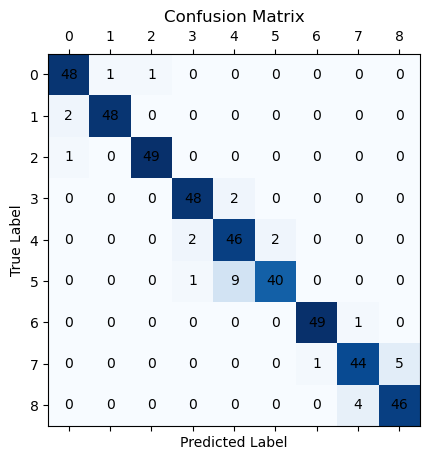

In [26]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

def convert_predictions_model1(predictions):
    prediction_map = {0: 9, 1: 3, 2: 4}
    return np.array([prediction_map[pred.item()] for pred in predictions])

def convert_predictions_model2(predictions):
    # Model 2: 4 -> 6, 5 -> 7, 6 -> 8
    prediction_map = {0: 0, 1: 1, 2: 2, 3: 5, 4: 6, 5: 7, 6: 8}
    return np.array([prediction_map[pred.item()] for pred in predictions])

# Test Model 1 on X_test
model1.eval()
y_pred_model1 = model1(X_test1).argmax(dim=1)
# Convert Model 1 predictions back to the original labels
y_pred_model1 = convert_predictions_model1(y_pred_model1)
others_mask = (y_pred_model1 == 9)

# For these "others", use Model 2 to predict the actual labels
X_others = X_test1[others_mask]  # Get the samples that were predicted as "others"
model2.eval()
y_pred_model2 = model2(X_others).argmax(dim=1)
# Convert Model 2 predictions back to the original labels
y_pred_model2 = convert_predictions_model2(y_pred_model2)

# Now, insert the Model 2 predictions back into the Model 1 predictions for "others"
y_pred_model1[others_mask] = y_pred_model2
y_test_numeric = y_test.cpu().numpy()

# Convert 'others' to a common label (e.g., 2), and map 4 -> 0, 5 -> 1
y_test_numeric = np.where(y_test_numeric == 4, 0, y_test_numeric)
y_test_numeric = np.where(y_test_numeric == 5, 1, y_test_numeric)
y_test_numeric = np.where(~np.isin(y_test_numeric, [0, 1]), 2, y_test_numeric)

def one_hot_to_single_label(y):
    return np.argmax(y, axis=1)  # Get the index of the max value in each row

# If y_test or y_pred_model1 are one-hot encoded, convert them to single labels
y_test_single = one_hot_to_single_label(y_test_numeric)  # Convert y_test to single labels
# Now calculate the accuracy and confusion matrix
accuracy = accuracy_score(y_test_single, y_pred_model1)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test_single, y_pred_model1)
print("Confusion Matrix:")
print(cm)

# 绘制混淆矩阵
plt.matshow(cm, cmap='Blues')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()